# Convolutional Neural Networks

In this notebook, you will learn about **Convolutional Neural Networks (CNNs)**, a type of neural network designed for processing structured grid data like images. CNNs use convolution operations to automatically learn spatial features, making them effective for tasks like image classification.

You will:
- Understand how convolution works as a feature detector
- See how convolution reduces parameters compared to fully connected networks
- Build CNNs using both `nn.Sequential` and custom `nn.Module` classes

## Setup

### Import Libraries

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path

import ipywidgets as widgets
import owncloud

### Utility Functions

In [3]:
def convolve1d_interactive(kernel_type: str = 'boxcar') -> None:

    a = np.zeros(100)
    a[30:70] = 1


    if kernel_type == 'boxcar':
        kernel = np.zeros(100)
        kernel[45:55] = 1
    elif kernel_type == 'gaussian':
        mu, sigma = 5, 0.5
        x = np.linspace(0,10,100)
        kernel = np.zeros_like(x)
        kernel[35:65] = np.exp(-(x[35:65] - mu)**2 / (2 * sigma**2))
    elif kernel_type == 'exponential':
        mu, tau = 5, 0.3
        x = np.linspace(0, 10, 100)
        kernel = np.zeros_like(x)
        kernel[35:50] = np.exp((x[35:50] - mu) / tau)  # Rising exponential on left, drops to 0 at peak
    else:
        raise ValueError(f"Unknown kernel_type: {kernel_type}. Use 'boxcar', 'gaussian', or 'exponential'.")

    result = np.zeros_like(a)

    def do_and_plot_convolution(idx):
        
        shifted_kernel = np.roll(kernel, idx-len(kernel) // 2)
        result[:idx+1] = [(a * np.roll(kernel, i - len(kernel) // 2)).sum() for i in range(idx+1)]
        
        fig, axes = plt.subplots(nrows = 2, figsize = (5,5))
        
        axes[0].plot(a, color = 'b', label = 'Original vector')
        axes[0].plot(shifted_kernel, color = 'g', label = f'Kernel at index {idx}')
        axes[1].plot(np.arange(len(a)), result)
        axes[1].set_ylabel('Result of Convolution')
        fig.legend(bbox_to_anchor = (1.6,0.8))
        plt.tight_layout()
        plt.show()

    slider = widgets.IntSlider(min = 10, max = len(a)-1, step = 1, description = 'index')
    widgets.interact(do_and_plot_convolution, idx=slider);


def convolve2d_horikernel_interactive():
    
    # Create a 2D image with lines
    img_size = 32
    image = np.zeros((img_size, img_size))
    
    # Horizontal line in top left corner
    image[6, 3:12] = 1
    
    # Vertical line in bottom right corner (5 pixels tall)
    image[20:29, 26] = 1
    
    # Create a 5x5 horizontal line kernel
    kernel_size = 5
    kernel = np.zeros((kernel_size, kernel_size))
    mid = kernel_size // 2
    kernel[mid, :] = 1  # Horizontal bar only
    kernel /= kernel.sum()  # Normalize
    
    # Result array
    result = np.zeros_like(image)
    
    def do_and_plot_convolution_2d(row, col):
        pad = kernel_size // 2
        
        # Reset result and compute up to current position
        result.fill(0)
        for r in range(row + 1):
            for c in range(col + 1):  # Only compute up to current column for ALL rows
                val = 0
                for ki in range(kernel_size):
                    for kj in range(kernel_size):
                        img_r = r + ki - pad
                        img_c = c + kj - pad
                        if 0 <= img_r < img_size and 0 <= img_c < img_size:
                            val += image[img_r, img_c] * kernel[ki, kj]
                result[r, c] = val
        
        # Create visualization
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        
        # Plot original image with kernel overlay
        axes[0].imshow(image, cmap='gray', vmin=0, vmax=1)
        axes[0].set_title('Original Image')
        # Draw kernel position as rectangle
        rect = plt.Rectangle((col - pad - 0.5, row - pad - 0.5), 
                              kernel_size, kernel_size, 
                              fill=False, edgecolor='red', linewidth=2)
        axes[0].add_patch(rect)
        axes[0].plot(col, row, 'r+', markersize=10, markeredgewidth=2)
        
        # Plot kernel
        axes[1].imshow(kernel, cmap='viridis')
        axes[1].set_title(f'Kernel ({kernel_size}x{kernel_size} horizontal)')
        
        # Plot convolution result
        axes[2].imshow(result, cmap='gray', vmin=0, vmax=1)
        axes[2].set_title('Convolution Result')
        axes[2].plot(col, row, 'r+', markersize=10, markeredgewidth=2)
        
        plt.tight_layout()
        plt.show()
    
    row_slider = widgets.IntSlider(min=0, max=img_size-1, step=1, value=0, description='row')
    col_slider = widgets.IntSlider(min=0, max=img_size-1, step=1, value=0, description='col')
    widgets.interact(do_and_plot_convolution_2d, row=row_slider, col=col_slider);


def convolve2d_vertikernel_interactive():
    
    # Create a 2D image with lines
    img_size = 32
    image = np.zeros((img_size, img_size))
    
    # Horizontal line in top left corner
    image[6, 3:12] = 1
    
    # Vertical line in bottom right corner (5 pixels tall)
    image[20:29, 26] = 1
    
    # Create a 5x5 vertical line kernel
    kernel_size = 5
    kernel = np.zeros((kernel_size, kernel_size))
    mid = kernel_size // 2
    kernel[:, mid] = 1  # vertical bar only
    kernel /= kernel.sum()  # Normalize
    
    # Result array
    result = np.zeros_like(image)
    
    def do_and_plot_convolution_2d(row, col):
        pad = kernel_size // 2
        
        # Reset result and compute up to current position
        result.fill(0)
        for r in range(row + 1):
            for c in range(col + 1):  # Only compute up to current column for ALL rows
                val = 0
                for ki in range(kernel_size):
                    for kj in range(kernel_size):
                        img_r = r + ki - pad
                        img_c = c + kj - pad
                        if 0 <= img_r < img_size and 0 <= img_c < img_size:
                            val += image[img_r, img_c] * kernel[ki, kj]
                result[r, c] = val
        
        # Create visualization
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        
        # Plot original image with kernel overlay
        axes[0].imshow(image, cmap='gray', vmin=0, vmax=1)
        axes[0].set_title('Original Image')
        # Draw kernel position as rectangle
        rect = plt.Rectangle((col - pad - 0.5, row - pad - 0.5), 
                              kernel_size, kernel_size, 
                              fill=False, edgecolor='red', linewidth=2)
        axes[0].add_patch(rect)
        axes[0].plot(col, row, 'r+', markersize=10, markeredgewidth=2)
        
        # Plot kernel
        axes[1].imshow(kernel, cmap='viridis')
        axes[1].set_title(f'Kernel ({kernel_size}x{kernel_size} vertical)')
        
        # Plot convolution result
        axes[2].imshow(result, cmap='gray', vmin=0, vmax=1)
        axes[2].set_title('Convolution Result')
        axes[2].plot(col, row, 'r+', markersize=10, markeredgewidth=2)
        
        plt.tight_layout()
        plt.show()
    
    row_slider = widgets.IntSlider(min=0, max=img_size-1, step=1, value=0, description='row')
    col_slider = widgets.IntSlider(min=0, max=img_size-1, step=1, value=0, description='col')
    widgets.interact(do_and_plot_convolution_2d, row=row_slider, col=col_slider);

def plot_toy_image(original_image, kernel=None):
    
    img_h, img_w = original_image.shape[1], original_image.shape[2]
    
    if kernel is not None:
        kernel_shape = kernel.weight[0, 0, :].shape
        stride_h, stride_w = kernel.stride
        k_h, k_w = kernel_shape[0], kernel_shape[1]
        
        positions_per_row = (img_w - k_w) // stride_w + 1
        positions_per_col = (img_h - k_h) // stride_h + 1
        max_steps = positions_per_row * positions_per_col - 1
    
    def do_plot(step=0):
        plt.imshow(original_image[0])
        for i in range(original_image.shape[1]):
            for j in range(original_image.shape[2]):
                plt.text(j, i, f'{int(original_image[0,i, j])}', ha='center', va='center', color='white', fontsize=12)

        if kernel is not None:
            row = (step // positions_per_row) * stride_h
            col = (step % positions_per_row) * stride_w
            
            rect = plt.Rectangle((col - 0.5, row - 0.5), k_w, k_h, 
                                 fill=False, edgecolor='red', linewidth=2)
            plt.gca().add_patch(rect)
        
        plt.show()
    
    if kernel is not None:
        step_slider = widgets.IntSlider(min=0, max=max_steps, step=1, value=0, description='step')
        widgets.interact(do_plot, step=step_slider)
    else:
        do_plot()

def train(model: nn.Module, images: torch.Tensor, labels: torch.Tensor, nepochs: int = 100) -> None:
        
    optimizer = torch.optim.Adam(model.parameters())
    loss_function = nn.CrossEntropyLoss()
    for epoch in range(nepochs):
        optimizer.zero_grad()

        output = model.forward(images)

        loss = loss_function(output, labels)

        loss.backward()

        optimizer.step()

class utils:
    convolve1d_interactive = convolve1d_interactive
    convolve2d_horikernel_interactive = convolve2d_horikernel_interactive
    convolve2d_vertikernel_interactive = convolve2d_vertikernel_interactive
    plot_toy_image = plot_toy_image
    train = train

### Download Data

In [7]:
Path('data').mkdir(exist_ok=True, parents=True)

owncloud.Client.from_public_link('https://uni-bonn.sciebo.de/s/6rBtQcJy7GeseaZ').get_file('/', f'data/stripe_dataset.pt')

True

In [9]:
data = torch.load('data/stripe_dataset.pt')
images = data['features']
labels = data['labels']


## Section 1: Convolution is a Weighted Filter and Can Work as a Feature Detector

Convolution is a mathematical operation that slides a small matrix (called a **kernel** or **filter**) across an input and computes weighted sums at each position. If the shape of a kernel matches the shape of the data, the output will have a higher amplitude. This property means that convolution with kernels can be used to detect features in images - from low-level features like edges or corners to more complex, high-level features like faces or buildings. Convolutional neural networks takes advantage of this property and combines convolutional layers with fully-connected layers (the kinds of networks we have worked with up until now).

#### **Exercises**

**Exercise**: Run the cell below to create an interactive plot where a vector is convolved with a boxcar. Drag the slider to perform the 1D convolution. The resulting line in the bottom plot is the weighted sum of the original vector and the kernel at that index. When is the result (the bottom plot) 0 and when is it at its max value?

In [10]:
utils.convolve1d_interactive('boxcar')

interactive(children=(IntSlider(value=10, description='index', max=99, min=10), Output()), _dom_classes=('widg…

**Exercise**: Run the cell below to create an interactive plot where a vector is convolved with a gaussian. Drag the slider to perform the 1D convolution. The resulting line in the bottom plot is the weighted sum of the original vector and the kernel at that index. Notice how the shape of the kernel affects the shape of the output here compared to the previous example.

In [11]:
utils.convolve1d_interactive('gaussian')

interactive(children=(IntSlider(value=10, description='index', max=99, min=10), Output()), _dom_classes=('widg…

**Exercise**: Run the cell below to create an interactive plot of a 2D convolution. The kernel, which is a horizontal stripe, is plotted in the middle. Drag the sliders to convolve the kernel with the image to the left. Look at the convolution result to the right: What happens when the kernel is convolved with the horizontal bar vs the vertical bar?

In [ ]:
utils.convolve2d_horikernel_interactive()

interactive(children=(IntSlider(value=0, description='row', max=31), IntSlider(value=0, description='col', max…

**Exercise**: Run the cell below to create an interactive plot of a 2D convolution.  The kernel, which is a vertical stripe, is plotted in the middle. Drag the sliders to convolve the kernel with the image to the left. Look at the convolution result to the right: What happens when the kernel is convolved with the horizontal bar vs the vertical bar now?

In [ ]:
utils.convolve2d_vertikernel_interactive()

interactive(children=(IntSlider(value=0, description='row', max=31), IntSlider(value=0, description='col', max…

You may have noticed that the bar whose orientation matched the orientation of the kernel was sharp in the resulting image, while the bar that was perpendicular was more smeared out. This demonstrates that kernels can serve as feature detectors in an image: Vertical kernels detect vertical edges, horizontal kernels detect horizontal edges etc. 

The classical study by [Hubel & Wiesel, 1959](https://pmc.ncbi.nlm.nih.gov/articles/PMC1363130/) demonstrated that neurons in the visual cortex exhibit such orientation selectivity. This later inspired the development of convolutional neural networks for image processing.

Run the cell below to create toy image data.

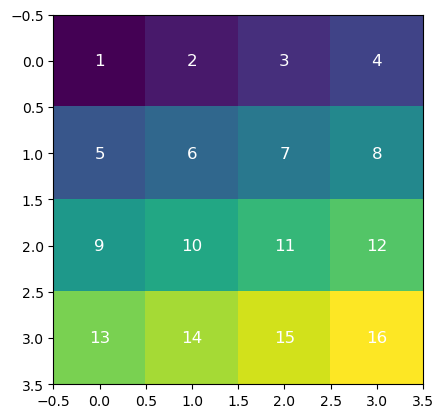

In [14]:
original_image = torch.tensor([
    [1.0, 2.0, 3.0, 4.0],
    [5.0, 6.0, 7.0, 8.0],
    [9.0, 10.0, 11.0, 12.0],
    [13.0, 14.0, 15.0, 16.0]
])

original_image = original_image.unsqueeze(0)
utils.plot_toy_image(original_image)

**Example**: Create a 2x2 convolutional kernel `kernel_size=(2,2)`  with a single input and output channel. Then, run the cell that creates an interactive plot of the original image with the kernel (the red box) overlayed.

In [15]:
conv2d = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(2,2))

When you drag the slider, the kernel moves along the image, just like the interactive plots in the previous exercises. When a convolution is carried out, the pixels inside the red box are multiplied with the weights of the kernel.

In [16]:
utils.plot_toy_image(original_image, conv2d)

interactive(children=(IntSlider(value=0, description='step', max=8), Output()), _dom_classes=('widget-interact…

**Exercise**: Create a 2x3 convolutional kernel `kernel_size=(2,3)` with a single input and output channel. Assign it to a variable named `conv2d`. Then, run the cell that creates an interactive plot of the original image with the kernel (the red box) overlayed. Drag the slider to move the kernel across the image.

In [17]:
conv2d = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(2,3), stride=1)

In [ ]:
utils.plot_toy_image(original_image, conv2d)

interactive(children=(IntSlider(value=0, description='step', max=5), Output()), _dom_classes=('widget-interact…

**Exercise**: Create a 3x3 convolutional kernel (`kernel_size=(3,3)`) with a single input and output channel. Then, run the cell that creates an interactive plot of the original image with the kernel (the red box) overlayed.

In [21]:
conv2d = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3,3))

In [ ]:
utils.plot_toy_image(original_image, conv2d)

interactive(children=(IntSlider(value=0, description='step', max=3), Output()), _dom_classes=('widget-interact…

## Section 2: Convolution lets us reduce the number of parameters and save computation

One of the main benefits of convolution is that it can reduce the number of parameters that need to be optimized in our model. The underlying assumption is that neighboring features are related; they contain similar information. For example, neighboring pixels in an image are often from the same object in the image. Therefore, we can aggregate the values in neighboring pixels, and this reduces the number of parameters that need to be trained, which makes training faster.

| Code | Description |
| --- | --- |
| `nn.Conv2d(in_channels, out_channels, kernel_size = (N,M))` | Creates a 2D convolution layer with the specified number of input channels, output channels, and kernel size. |
| `nn.Conv2d(in_channels, out_channels, kernel_size = (N,M), stride = 2)` | Creates a 2D convolution layer with a specified stride (how many pixels the kernel jumps between steps). |
| `output = conv2d(image)` | Apply the convolution to an image tensor and store the result. |

Run the cell below to create toy image data.

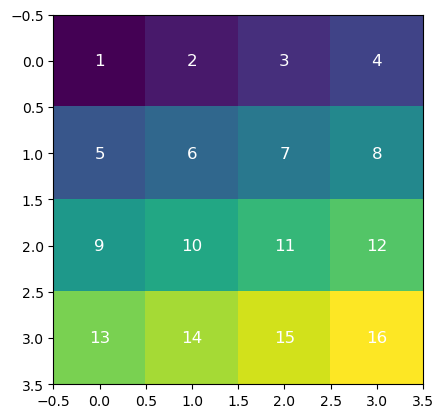

In [23]:
original_image = torch.tensor([
    [1.0, 2.0, 3.0, 4.0],
    [5.0, 6.0, 7.0, 8.0],
    [9.0, 10.0, 11.0, 12.0],
    [13.0, 14.0, 15.0, 16.0]
])

original_image = original_image.unsqueeze(0)
utils.plot_toy_image(original_image)

**Example**: Create a 2x2 convolutional kernel (`kernel_size=(2,2)`)  with a single input and output channel. Then, convolve the original image with the kernel and check the shape of the output. Run the cell that illustrates the convolution with the kernel below. Can you figure out why the output has the shape that it has?

**Note**: The first dimension when you check the shape is just the number of output channels. Focus on the last two numbers in the shape.

In [24]:
conv2d = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(2,2))

output = conv2d(original_image)
print(f'original image shape: {original_image.shape}')
print(f'output shape: {output.shape}')

original image shape: torch.Size([1, 4, 4])
output shape: torch.Size([1, 3, 3])


In [25]:
utils.plot_toy_image(original_image, conv2d)

interactive(children=(IntSlider(value=0, description='step', max=8), Output()), _dom_classes=('widget-interact…

**Exercise**: Create a 3x3 convolutional kernel `kernel_size=(3,3)`  with a single input and output channel. Then, convolve the original image with the kernel and check the shape of the output. Run the cell that illustrates the convolution with the kernel below. Can you figure out why the output has the shape that it has?

**Note**: The first dimension is just the number of output channels.

In [26]:
utils.plot_toy_image(original_image, conv2d)

interactive(children=(IntSlider(value=0, description='step', max=8), Output()), _dom_classes=('widget-interact…

**Exercise**: Create a 2x3 convolutional kernel `kernel_size=(2,3)`  with a single input and output channel. Then, convolve the original image with the kernel and check the shape of the output. Run the cell that illustrates the convolution with the kernel below. Can you figure out why the output has the shape that it has?

**Note**: The first dimension in the shape is just the number of output channels.

In [43]:
utils.plot_toy_image(original_image, conv2d)

interactive(children=(IntSlider(value=0, description='step', max=5), Output()), _dom_classes=('widget-interact…

Unless you have a 1x1 kernel, the output has fewer rows and/or columns than the original image. In other words, we have reduced the size of the data, and this, in turn, is what reduces the computational resources needed when a model is trained on the convolved image rather than the original image.

The size of the convolved image can be reduced further by introducing "stride". Stride is how many pixels the kernel should jump between each step in the convolution.

**Example**: Create a 2x1 convolutional kernel `kernel_size=(2,1)` with `stride = 2`. Then, convolve the original image with the kernel and check the shape of the output. If you run the cell with the interactive plot you can see the effect of stride.

In [27]:
conv2d = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(2,1), stride = 2)

output = conv2d(original_image)
print(f'original image shape: {original_image.shape}')
print(f'output shape {output.shape}')

original image shape: torch.Size([1, 4, 4])
output shape torch.Size([1, 2, 2])


When you drag the slider, how many pixels either columnwise or rowwise does the kernel jump with each step?



In [ ]:
utils.plot_toy_image(original_image, conv2d)

interactive(children=(IntSlider(value=0, description='step', max=3), Output()), _dom_classes=('widget-interact…

**Exercise**: Create a 2x1 convolutional kernel `kernel_size=(2,1)` with `stride = 3`. Then, convolve the original image with the kernel and check the shape of the output. If you run the cell with the interactive plot you can see the effect of stride.

When you drag the slider, how many pixels either columnwise or rowwise does the kernel jump with each step? Note that the kernel can't jump outside of the image (the way we have defined it here), that's why it doesn't jump down.



In [29]:
utils.plot_toy_image(original_image, conv2d)

interactive(children=(IntSlider(value=0, description='step', max=3), Output()), _dom_classes=('widget-interact…

**Exercise**: Below, a 2x2 convolutional kernel `kernel_size=(2,2)` with `stride = 2` is created and the weights of the kernel are set equal to `1`. Convolve the kernel with the original image and assign the result to a variable named `output`.

In [30]:
original_image = torch.tensor([
    [1.0, 2.0, 3.0, 4.0],
    [5.0, 6.0, 7.0, 8.0],
    [9.0, 10.0, 11.0, 12.0],
    [13.0, 14.0, 15.0, 16.0]
]) - torch.tensor(5)

original_image = original_image.unsqueeze(0)

conv2d = nn.Conv2d(1, 1, (2,2), stride=2, bias=False)

with torch.no_grad(): 
    conv2d.weight[:] = torch.ones_like(conv2d.weight[:])

Run the cell below to visualize the output. The number inside each square is the result of convolving the kernel with the pixels inside it. In a cell further down, an interactive visualization is created. Try summing up the numbers inside the red box in each step and see if it matches the numbers in the output plot.

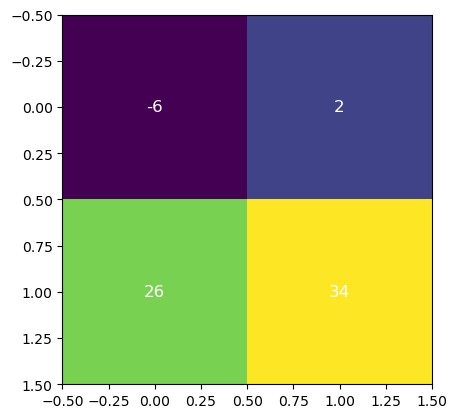

In [81]:
utils.plot_toy_image(output.detach())

In [82]:
utils.plot_toy_image(original_image, conv2d)

interactive(children=(IntSlider(value=0, description='step', max=3), Output()), _dom_classes=('widget-interact…

## Section 3: Making a CNN and Applying it to Data

In this section, we'll build Convolutional Neural Networks (CNNs) using `nn.Sequential` and apply these networks to a simple toy dataset to see how CNNs process images.

### Code Reference Table

| Code | Description |
| :-- | :-- |
| `nn.Sequential(nn.Conv2d(...), nn.Flatten(), )` | Creates a container that passes input through layers in order. |
| `nn.Conv2d(in_channels, out_channels, kernel_size = (NxM))` | 2D convolution layer. `in_channels` is input depth (e.g., 1 for grayscale), `out_channels` is number of filters. |
| `nn.ReLU()` | Creates ReLU activation function. |
| `nn.Flatten()` | Flattens all dimensions except batch into a single vector. Required before `nn.Linear` in CNNs. |
| `nn.Linear(in_features, out_features)` | Fully connected layer. Maps `in_features` inputs to `out_features` outputs in CNN. |

**Visualize Sample Images**

Run the cell below to see examples of the toy image data. We have two classes of images: One with horizontal stripes and one with vertical stripes. (The grey pixels are just added noise.)

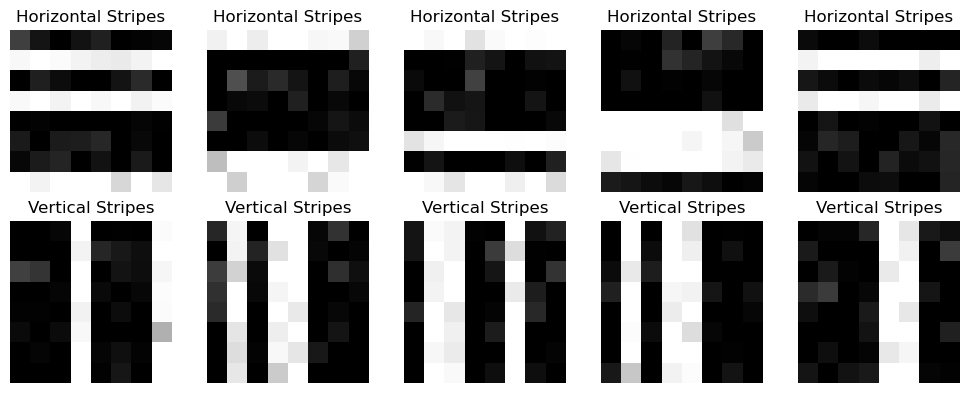

In [31]:
# Visualize sample images from the toy dataset
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
class_names_toy = ['Horizontal Stripes', 'Vertical Stripes']

# Show 5 horizontal stripe images
horizontal_idx = torch.where(labels == 0)[0][:5]
for i, idx in enumerate(horizontal_idx):
    axes[0, i].imshow(images[idx, 0], cmap='gray', vmin=0, vmax=1)
    axes[0, i].set_title(f'{class_names_toy[0]}')
    axes[0, i].axis('off')

# Show 5 vertical stripe images
vertical_idx = torch.where(labels == 1)[0][:5]
for i, idx in enumerate(vertical_idx):
    axes[1, i].imshow(images[idx, 0], cmap='gray', vmin=0, vmax=1)
    axes[1, i].set_title(f'{class_names_toy[1]}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

To create a (simple) convolutional neural network, we use three basic ingredients:

1. A convolutional layer. `Conv2d` layer
2. A `Flatten` layer. This flattens the output from the convolutional layer so that it can be fed to a dense neural network.
3. A dense neural network: A `Linear` layer (+ activation functions)

**Example**: Create the simplest possible CNN using `nn.Sequential`. It should have:
1. A single `Conv2d` layer: 1 input channel, 4 output channels, 3x3 kernel
2. A `Flatten` layer
3. A `Linear` layer that outputs 2 classes

For images of shape 8x8, the resulting output after a convolution with a 3x3 kernel will have the shape 6x6. With 1 output channel, the flattened size is 1 × 6 × 6 = 36.

In [36]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3),   # 1x8x8 -> 1x6x6
    nn.Flatten(),                                              # flattens the output from the convolution layer from 1x6x6 to 36
    nn.Linear(6 * 6, 2)                                        # 36 -> 2 classes
)

print(model)

Sequential(
  (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=36, out_features=2, bias=True)
)


Run the cell below to apply the untrained CNN to a single image.

In [37]:
# Run on a single image (no training yet)
single_image = images[0:1]
single_label = labels[0:1]

with torch.no_grad():
    output = model(single_image)

print(f"Predicted class: {output.argmax(dim=1).item()}")
print(f"True class: {single_label.item()} ({class_names_toy[single_label.item()]})")

Predicted class: 0
True class: 1 (Vertical Stripes)


Run the cell below to check how accurate the **untrained** CNN is on the entire dataset. Since it has random weights, the accuracy should be close to 50% (random guessing for 2 classes).

In [38]:
with torch.no_grad():
    outputs = model(images)
    predictions = outputs.argmax(dim=1)
    accuracy = (predictions == labels).float().mean()

print(f"Accuracy without training: {accuracy:.2%}")

Accuracy without training: 58.50%


**Exercise**: Create a CNN using `nn.Sequential`. It should have:
1. A single `Conv2d` layer: `1` input channel, `4` output channels, `3x3` kernel
2. A `Flatten` layer
3. A `Linear` layer that outputs 2 classes

The number of output channels represents the number of filters, or kernels, used. You can use different filters that can detect different things in the image. In this exercise, we use 4 filters.

In [ ]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3),  # 1x8x8 -> 4x6x6
    ___,                                                      # UPDATE ME - flattens the output from the convolution layer from 4x6x6 to 144
    nn.Linear(___, 2)                                         # UPDATE ME - 144 -> 2 classes
)

print(model)

TypeError: empty(): argument 'size' failed to unpack the object at pos 2 with error "type must be tuple of ints,but got Tensor"

Run the cell below to train the model.

In [251]:
utils.train(model, images, labels)

Run the cell below to check how accurate the **trained** CNN is on the entire dataset.

**Note**: It's to be expected that the accuracy is still not very high.

In [252]:
with torch.no_grad():
    outputs = model(images)
    predictions = outputs.argmax(dim=1)
    accuracy = (predictions == labels).float().mean()

print(f"Accuracy with training: {accuracy:.2%}")

Accuracy with training: 57.50%


**Exercise**: Add a `ReLU` activation after the convolutional layer.

Create a CNN with:
1. `Conv2d`: 1 input channel, 4 output channels, 3x3 kernel
2. `ReLU`: activation function
3. `Flatten`
4. `Linear`: outputs 2 classes

Run the cell below to train the model.

In [254]:
utils.train(model, images, labels)

Run the cell below to check how accurate the **trained** CNN is on the entire dataset. How high is the accuracy now?

In [255]:
with torch.no_grad():
    outputs = model(images)
    predictions = outputs.argmax(dim=1)
    accuracy = (predictions == labels).float().mean()

print(f"Accuracy with training: {accuracy:.2%}")

Accuracy with training: 99.50%


**Exercise**: Create a model with two convolutional layers. Deeper networks can learn more complex features.

Create a CNN with:
1. `Conv2d`: 1 input channel and 4 output channels, 3x3 kernel
2. `ReLU`
3. `Conv2d`: 4 input channels and 2 output channels, 2x2 kernel
4. `ReLU`
5. `Flatten`
6. `Linear`: outputs 2 classes

In [ ]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(3,3)),   # 1x8x8 -> 4x6x6
    nn.ReLU(),
    ___,   #  UPDATE ME - 4x6x6 -> 2x5x5
    ___,   # UPDATE ME
    nn.Flatten(),                                              # 2x5x5 = 50
    nn.Linear(2 * 5 * 5, 2)
)

print(model)

## Section 4: Create CNNs with Object-Oriented Programming

While `nn.Sequential` is convenient for simple feed-forward networks, PyTorch's object-oriented approach using `nn.Module` gives you full control over your model architecture. By defining a custom class, you can implement complex behaviors like skip connections, conditional logic, and multiple outputs that aren't possible with `nn.Sequential`.


| Code | Description |
| :-- | :-- |
| `class Model(nn.Module)`<br>&nbsp;&nbsp;&nbsp;&nbsp;`...` | Define a class named `Model` that inherits from `nn.Module`. |
| `class Model(nn.Module)`<br>&nbsp;&nbsp;&nbsp;&nbsp;`def __init__(self):`<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; `super().__init__()` | Define a class named `Model` that inherits from `nn.Module`.<br>`super().__init__()` initializes the parent `nn.Module`. |
| `class Model(nn.Module)`<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`def __init__(self):`<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; `...` <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; `self.conv = nn.Conv2d(1,4,3)` | Add a convolutional layer with 1 input channel, 4 output channels, and a 3x3 kernel to the model. |
| `class Model(nn.Module)`<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`def __init__(self):`<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; `...` <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; `self.conv = nn.Conv2d(1,4,3)`  <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; `self.fc = nn.Linear(144,2)` | Add a convolutional layer and a fully connected layer to the model. |
| `class Model(nn.Module)`<br>&nbsp;&nbsp;&nbsp;&nbsp;`def __init__(self):`<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; `...`<br><br>&nbsp;&nbsp;&nbsp;&nbsp;`def forward(self,x):`<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`out = self.conv(x)`<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`return self.fc(out)` | Add a method `forward` to the model that carries out the forward pass of the input `x` through the network. |
| `model = Model()` | Create an instance of `Model` and assign it to a variable named `model`. |

**Example** Create the model below with a custom class that inherits from `nn.Module` instead of using `nn.Sequential`.

In [ ]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3),  # 8x8 -> 6x6
    nn.Flatten(),                                              # flattens the output from the convolution layer from 1*6*6 to 36
    nn.Linear(6 * 6, 2)                                        # 36 -> 2 classes
)

model

Sequential(
  (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=36, out_features=2, bias=True)
)

In [258]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        # define the layers
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(6 * 6, 2)
    
    def forward(self, x):
        x = self.conv(x)      
        x = self.flatten(x)
        x = self.fc(x)
        return x

# create an instance of the model
model = Model()

**Exercise** Create the model below with a custom class that inherits from `nn.Module` instead of using `nn.Sequential`.

In [259]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(3,3)),  # 8x8 -> 6x6
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(4 * 6 * 6, 2)
)

In [265]:
# create an instance of the model
model = Model()

**Exercise** Create the model below with a custom class that inherits from `nn.Module` instead of using `nn.Sequential`.

In [ ]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(3,3)),   # 1x8x8 -> 4x6x6
    nn.ReLU(),
    nn.Conv2d(in_channels=4, out_channels=2, kernel_size=(2,2)),   # 4x6x6 -> 2x5x5
    nn.ReLU(),
    nn.Flatten(),                                              # 2x5x5 = 50
    nn.Linear(2 * 5 * 5, 2)
)

print(model)

**Demo**: The following models cannot be created using `nn.Sequential`:

CNN with conditional logic in forward pass. We might be applying the model to data that has 2 classes or 10 classes. The if-statement makes sure that we use the right fully-connected network depending on what applies to the data.

In [ ]:
 class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 4, 3)
        self.fc1 = nn.Linear(144, 2)
        self.fc2 = nn.Linear(144, 10)
    
    def forward(self, x, num_classes=2):
        out = self.conv(x)
        out = out.flatten(1)
        # different paths based on condition
        if num_classes == 2:
            return self.fc1(out)
        else:
            return self.fc2(out)

CNN with skip connections. A real-world example of a network with this kind of architecture is the [U-net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) - a model that's used for biomedical image segmentation.

In [ ]:
class SkipModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=2, kernel_size=1)  # 8 = 4 + 4 from skip
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(2 * 8 * 8, 2)
    
    def forward(self, x):
        # first conv block
        skip = self.relu1(self.conv1(x))  # (skip connection)
        
        # second conv block
        x = self.relu2(self.conv2(skip))
        
        # concatenate skip connection
        x = torch.cat([x, skip], dim=1)  # This is why we can't use nn.Sequential
        
        # final layers
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc(x)
        
        return x